In [2]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from resnet_model.data_loading import *
from resnet_model.read_data import *

import torchvision.transforms as transforms


/Users/lisavind/miniconda3/envs/ml_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lisavind/miniconda3/envs/ml_env/lib/python3.9/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace (__ZN3c1017RegisterOperatorsD1Ev)
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def open_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    return data

In [4]:
path_df = '/Volumes/T7 Shield/AntProject/colour_ants.csv'
images_dir = '/Volumes/T7 Shield/AntProject/original'

In [10]:
file_path = "output_training/output_resnet_1layer_10epochs/target_colors_thorax.pkl"

target_colors = open_pickle(file_path)

In [12]:
file_path = "output_training/output_resnet_1layer_10epochs/output_colors_thorax.pkl"

output_colors = open_pickle(file_path)

In [13]:
mean_value = torch.tensor([0.485, 0.456, 0.406])
std_value = torch.tensor([0.229, 0.224, 0.225])

# Unnormalize the tensors
def unnormalize(tensors, mean, std):
    unnormalized = [(tensor * std) + mean for tensor in tensors]
    return [t.numpy() for t in unnormalized]  # Convert to NumPy arrays

def convert(tensors):
    return [t.numpy() for t in tensors] 

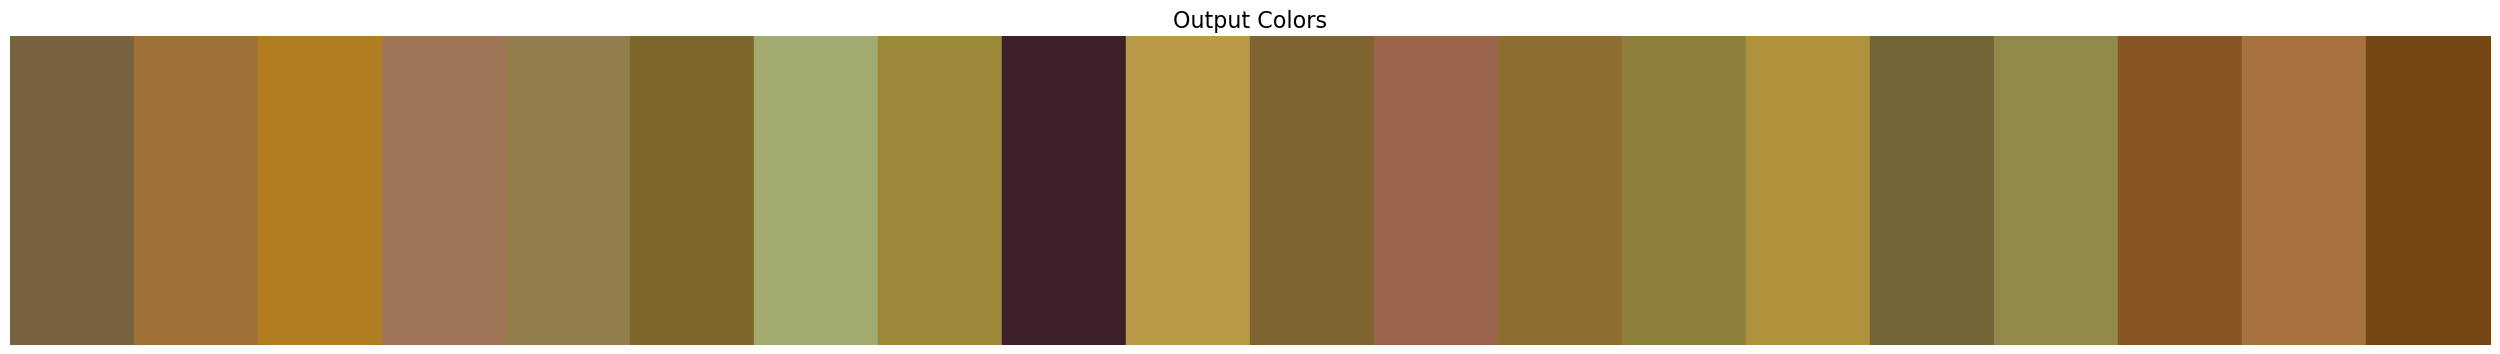

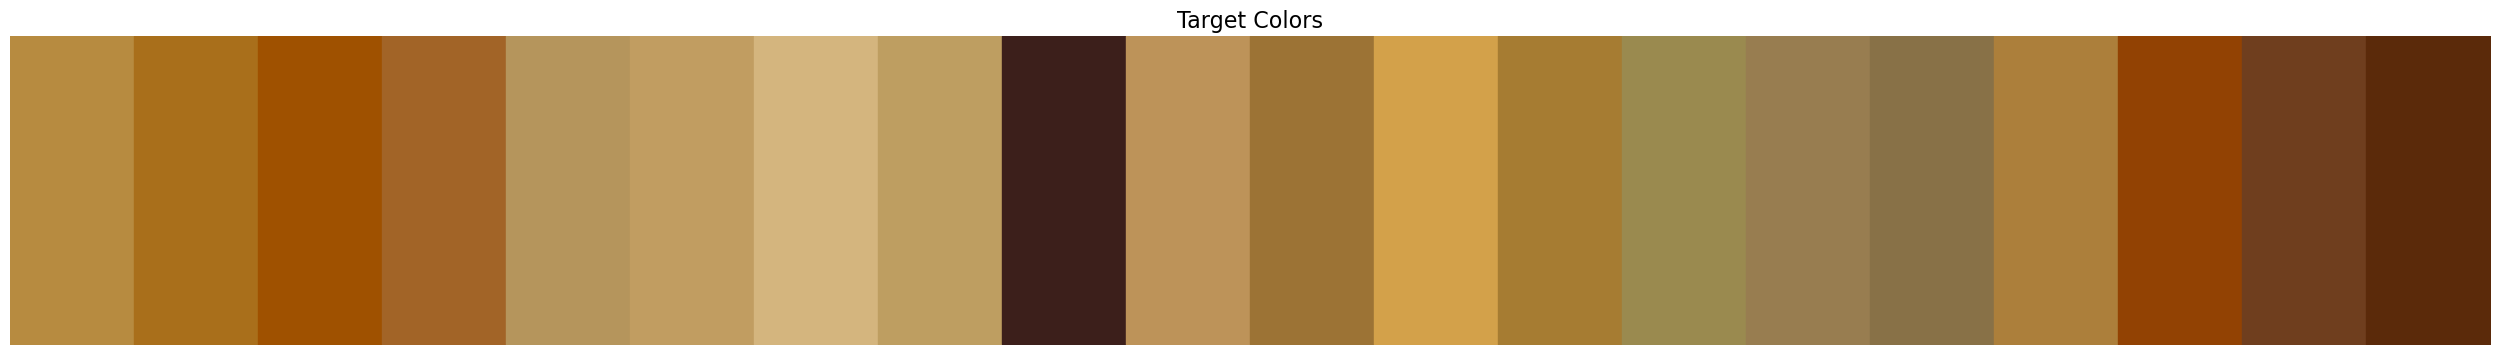

In [14]:
def plot_rgb_blocks(color_list, title, max_colors=None):
    if max_colors is not None:
        color_list = color_list[:max_colors]  # Slice the list to include only the specified number of colors

    plt.figure(figsize=(max(32, len(color_list)), 4))  # Adjust figure width dynamically
    for i, color in enumerate(color_list):
        color_rgb = np.clip(color, 0, 1)  # Ensure values are between 0 and 1
        plt.fill_between([i, i + 1], 0, 1, color=color_rgb)
        
    plt.xlim(0, len(color_list))
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

#output_colors_unnorm = unnormalize(output_colors[4], mean_value, std_value)
#target_colors_unnorm = unnormalize(target_colors[4], mean_value, std_value)

# Plot output and target colors
plot_rgb_blocks(convert(output_colors[0]), "Output Colors",max_colors = 20)
plot_rgb_blocks(convert(target_colors[0]), "Target Colors",max_colors = 20)

In [15]:
mean_value = [0.485, 0.456, 0.406]
std_value= [0.229, 0.224, 0.225]

df = pd.read_csv(path_df)

# Standardize the columns
df['r_thorax'] = df['r_thorax'] / 255.0
df['g_thorax'] = df['g_thorax'] / 255.0
df['b_thorax'] = df['b_thorax'] / 255.0

specimen_set = set(df['specimen'])  # Convert to a set for faster lookup

image_file_names = read_image_file_names(images_dir)

image_file_set = set(image_file_names)

# Filter the DataFrame by checking if 'original_file' is in image_file_set
filtered_df = df[df['original_file'].isin(image_file_set)]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

#train_dataset = ImageLabelDataset(images_dir,filtered_df,transform, split='train')
val_dataset = ImageLabelDataset(images_dir,filtered_df,transform, split='val')


File is empty: /Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg


Image shape: torch.Size([3, 224, 224])


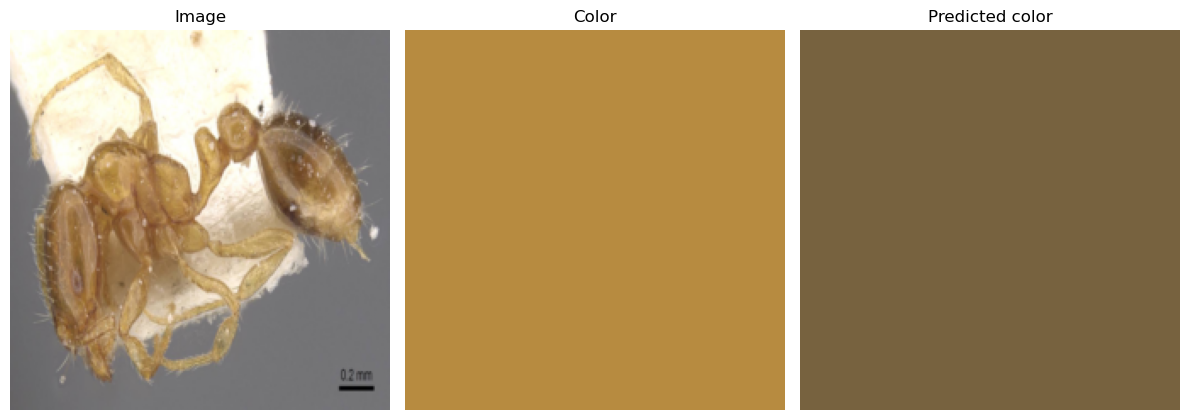

Image shape: torch.Size([3, 224, 224])


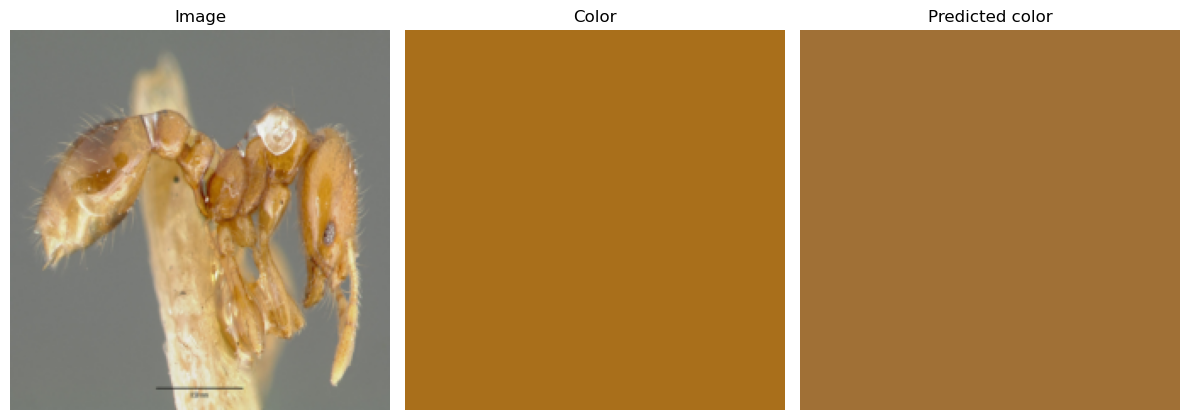

Image shape: torch.Size([3, 224, 224])


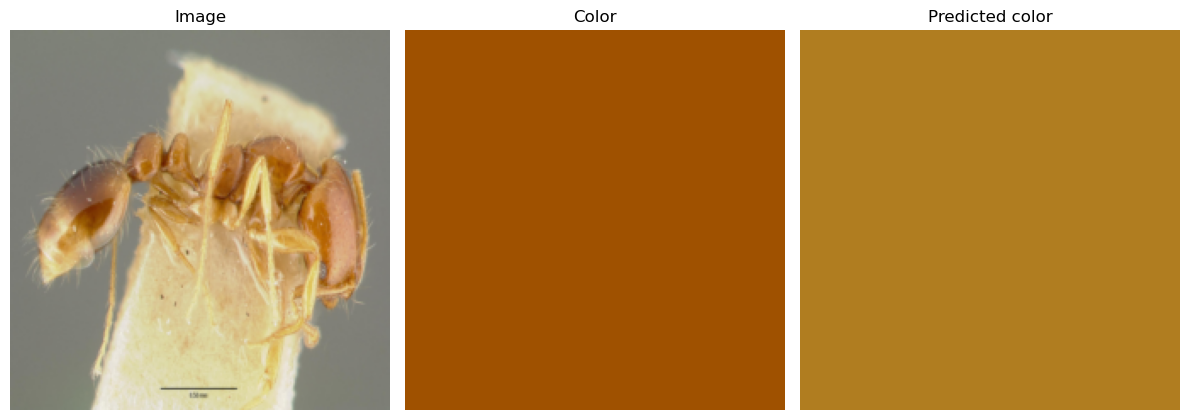

Image shape: torch.Size([3, 224, 224])


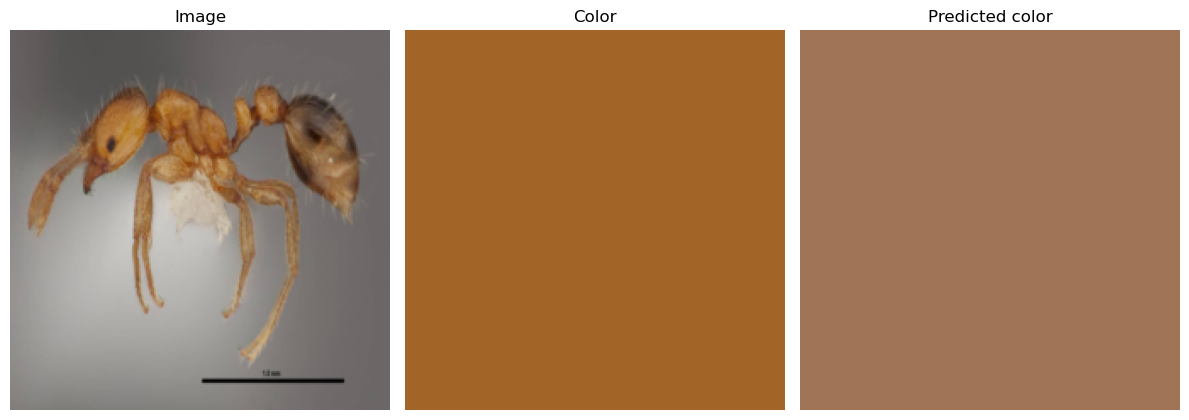

Image shape: torch.Size([3, 224, 224])


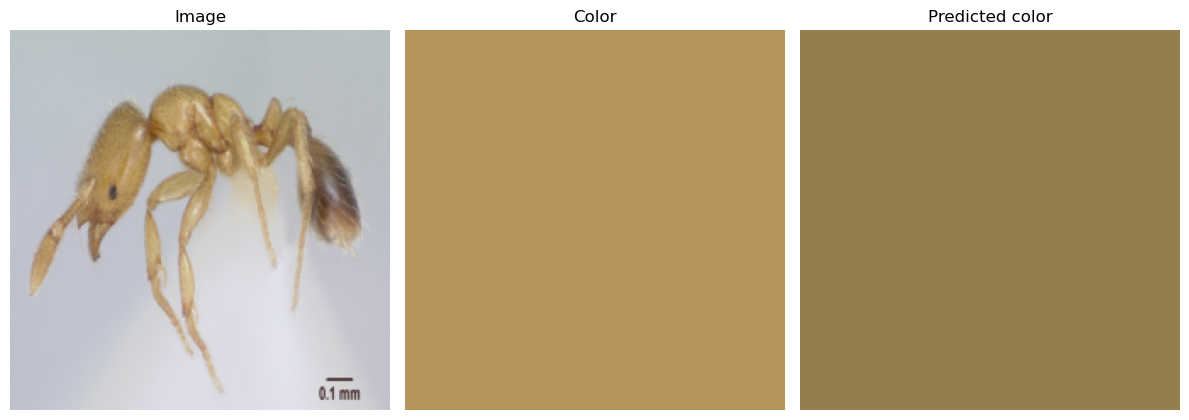

Image shape: torch.Size([3, 224, 224])


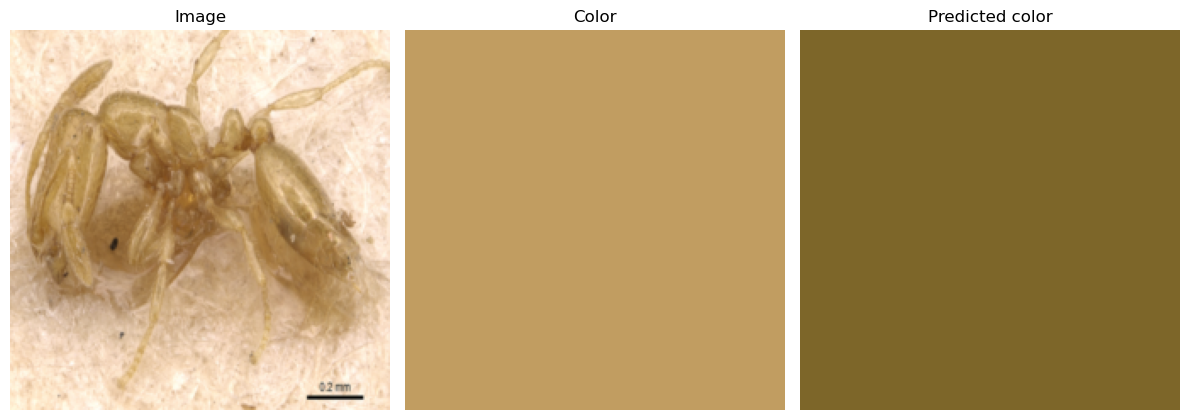

Image shape: torch.Size([3, 224, 224])


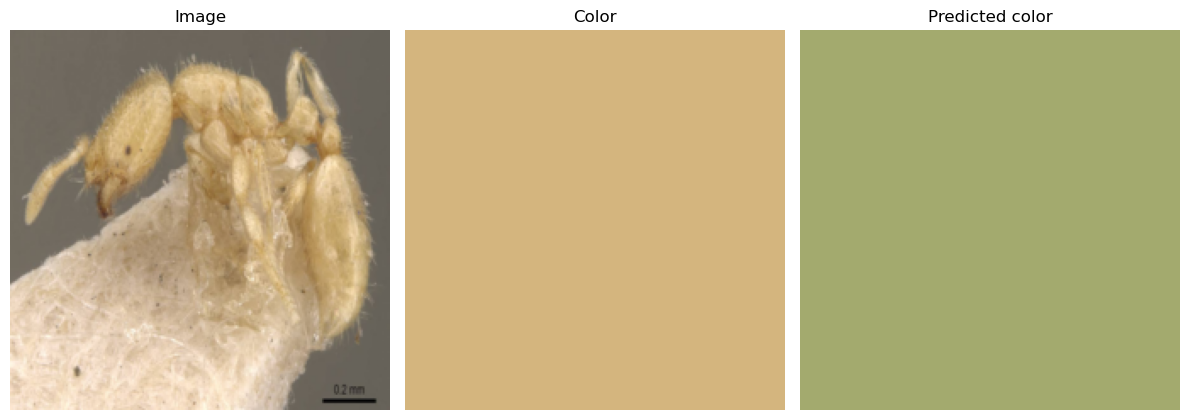

Image shape: torch.Size([3, 224, 224])


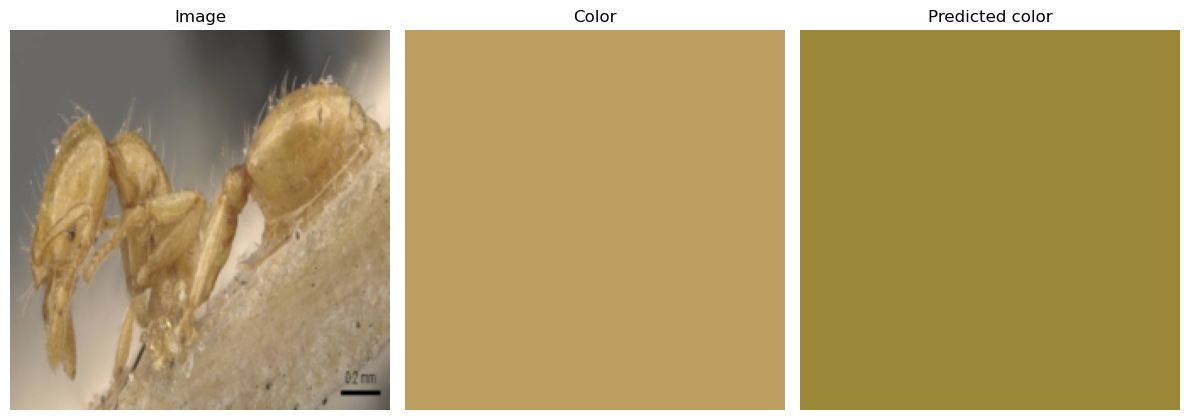

Image shape: torch.Size([3, 224, 224])


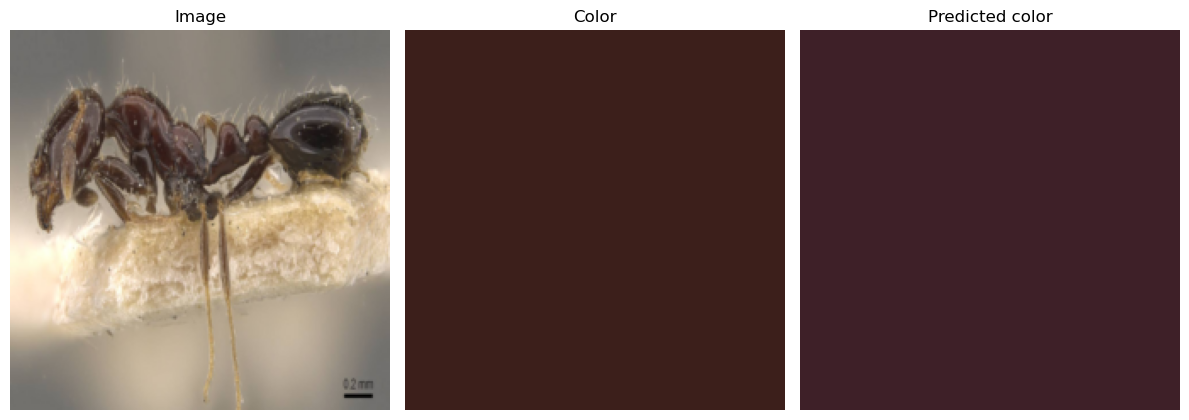

Image shape: torch.Size([3, 224, 224])


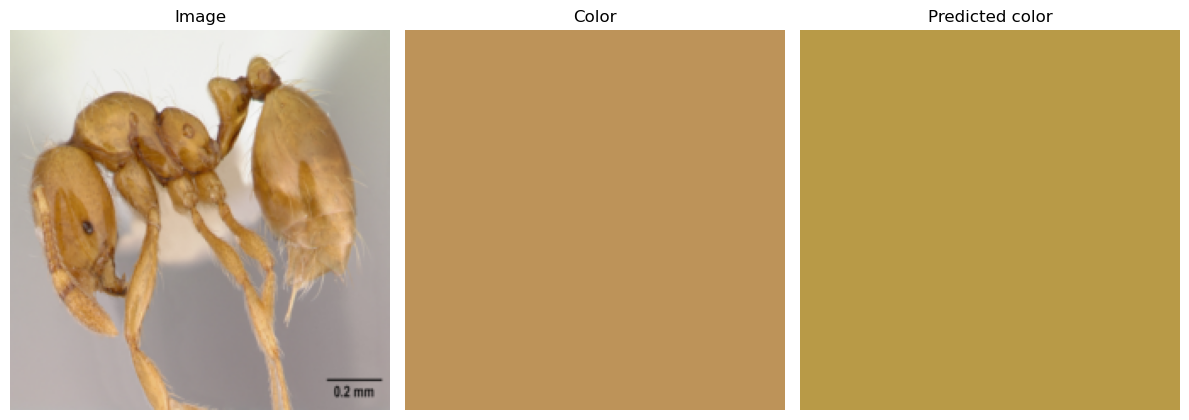

Image shape: torch.Size([3, 224, 224])


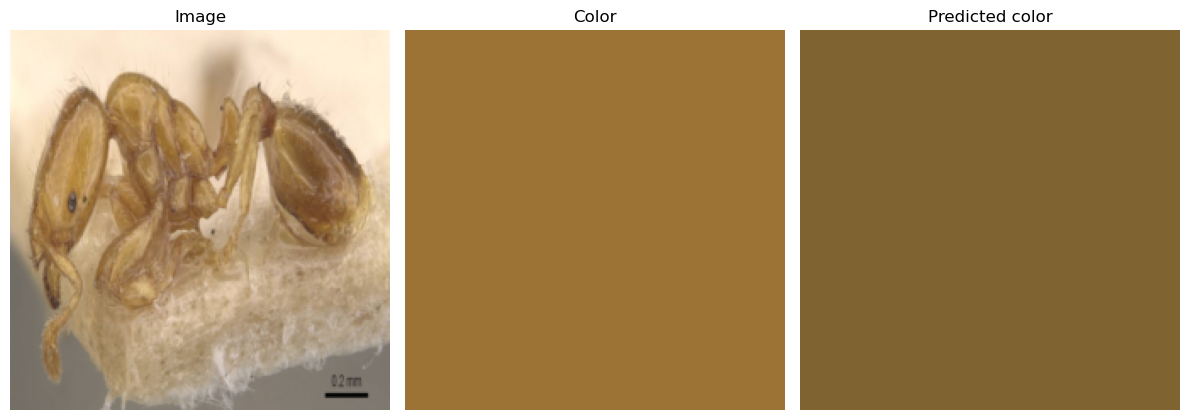

In [17]:
output_colors_np = convert(output_colors[0])
for i, (img, label) in enumerate(val_dataset):
    print(f"Image shape: {img.shape}")

    # Convert tensors to numpy arrays for visualization
    img_np = img.permute(1, 2, 0).numpy()

    label = label.numpy()
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(img_np)
    ax[0].set_title("Image")
    ax[0].axis("off")

    rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(label)#  * np.array(label)/255
    rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[i]
    
    ax[1].imshow(rgb_image)
    ax[1].set_title("Color")
    ax[1].axis("off")

    ax[2].imshow(rgb_target)
    ax[2].set_title("Predicted color")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

    if i == 10:
        break

Try runing model without standardizing the data!

### Plot evaluation matrics

In [185]:
def convert_values_to_numpy(output_tensor):
    output_np = []
    for batch in output_tensor:
        for value in batch:
            output_np.append(value.numpy())

    return np.array(output_np)

In [226]:
target_colors_np = convert_values_to_numpy(target_colors)
output_colors_np = convert_values_to_numpy(output_colors)

#se = np.sum((target_colors_np - output_colors_np), axis = 1) ** 2
se = (target_colors_np - output_colors_np) ** 2
mse = np.mean(se, axis = 0)
print(f"MSE for all batches: {mse}")

MSE for all batches: [0.01351287 0.01086648 0.00861919]


In [204]:
#Mean square error per color channel
se_sorted_index = np.argsort(se)

In [207]:
lowest_10_indices = se_sorted_index[:10]
highest_10_indices = se_sorted_index[-10:]

In [217]:
def plot_colors(target_colors_np,output_colors_np, index):

    for i in range(0,len(index)):
        fig, ax = plt.subplots(1, 2, figsize=(2, 2))
        rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(target_colors_np[index[i]])#  * np.array(label)/255
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[index[i]]

        ax[0].imshow(rgb_image)
        ax[0].set_title("Color")
        ax[0].axis("off")

        ax[1].imshow(rgb_target)
        ax[1].set_title("Predicted color")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()



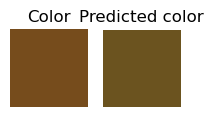

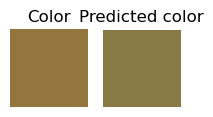

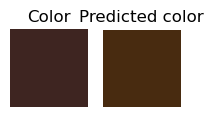

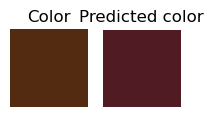

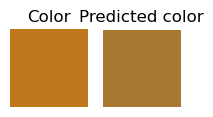

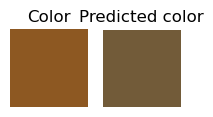

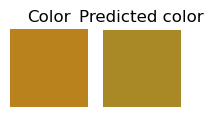

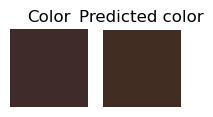

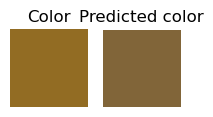

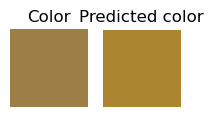

In [218]:
plot_colors(target_colors_np,output_colors_np, lowest_10_indices)

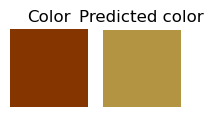

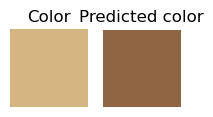

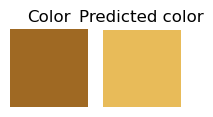

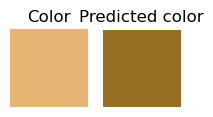

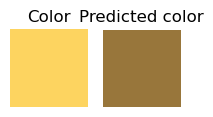

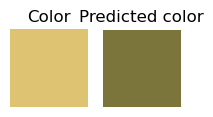

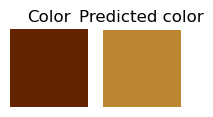

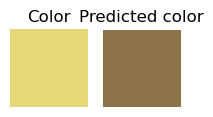

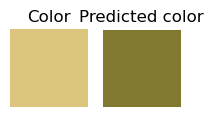

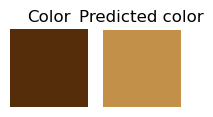

In [219]:
plot_colors(target_colors_np,output_colors_np, highest_10_indices)

### Plot colors

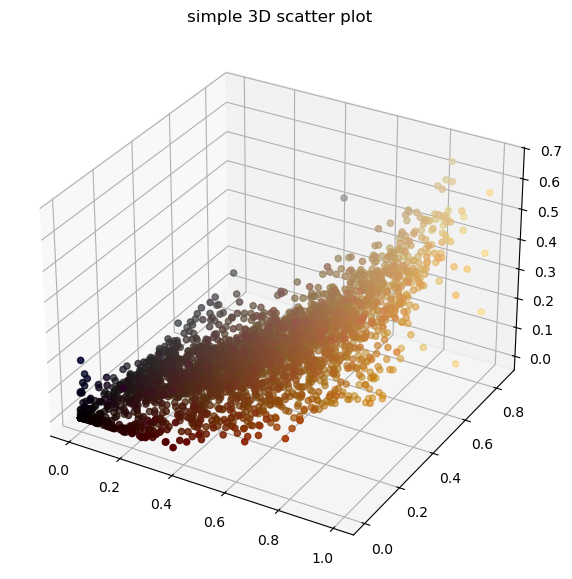

In [220]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2]))

# Creating plot
ax.scatter3D(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [223]:
output_colors_np

out_of_bounds = (output_colors_np < 0) | (output_colors_np > 1)

if np.any(out_of_bounds):
    print("Some values are out of bounds. Clipping them to the range [0, 1].")
    output_colors_np = np.clip(output_colors_np, 0, 1)
else:
    print("All values are within the range [0, 1].")


Some values are out of bounds. Clipping them to the range [0, 1].


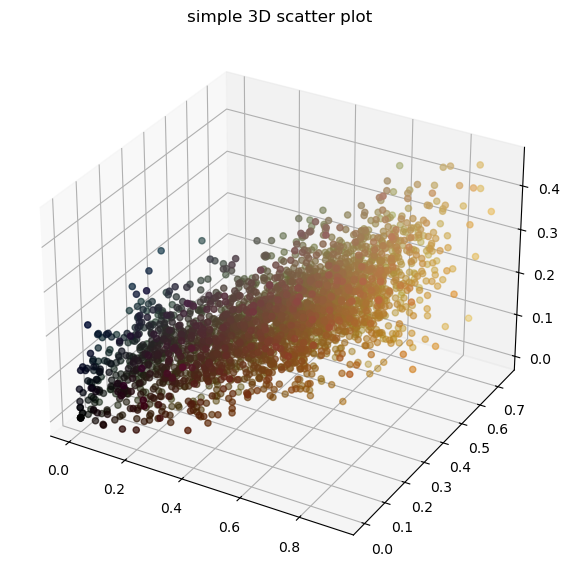

In [224]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2]))

# Creating plot
ax.scatter3D(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

I feel like the prediction looks "linear". Maybe add another layer. The fully connected layer can only produce inear functions??

### Trying to find the represatentative pixel:

In [ ]:
#Every image calculate the closest pixel 